# ArcticDEM

Find, download, coregister, and stack ArcticDEM strip DEMs

In [2]:
import geopandas as gpd
import numpy as np
import pdemtools as pdt
import xarray as xr
from rasterio.enums import Resampling

# Metadata for final Dataset
GLOBAL_ATTRS = {
    "author": "Porter and others",
    "institution": "Polar Geospatial Center (PGC), College of Science and Engineering, University of Minnesota",
    "region": "RGI05A",
    "projection": "3413",
    "title": "ArcticDEM strip DEMs",
    "version": "v4.1",
}
VAR_ATTRS = {
    "x": {
        "description": "x coordinate of projection",
        "units": "metres",
    },
    "y": {
        "description": "y coordinate of projection",
        "units": "metres",
    },
    "glacier": {
        "description": "Glacier name, as taken from the Mouginot and others (2019) Greenland basins dataset",
    },
    "h": {
        "description": "Elevation relative to the WGS84 ellipsoid",
        "units": "metres",
    },
    "mosaic": {
        "description": "Elevation relative to the WGS84 ellipsoid from ArcticDEM mosaic",
        "units": "metres",
    },
    "coreg_rmse": {
        "description": "Final RMSE of the coregistration transformation in the vertical (z) dimension from the residuals",
        "units": "metres",
    },
    "coreg_trans_z": {
        "description": "z transformation paramater",
        "units": "metres",
    },
    "coreg_trans_x": {
        "description": "x transformation paramater",
        "units": "metres",
    },
    "coreg_trans_y": {
        "description": "y transformation paramater",
        "units": "metres",
    },
    "coreg_trans_z_err": {
        "description": "1-sigma error of the z transformation paramater",
        "units": "metres",
    },
    "coreg_trans_x_err": {
        "description": "1-sigma error of the x transformation paramater",
        "units": "metres",
    },
    "coreg_trans_y_err": {
        "description": "1-sigma error of the y transformation paramater",
        "units": "metres",
    },
    "acqdate1": {
        "description": "Acquisition date for Image 1 of the stereopair",
    },
    "acqdate2": {
        "description": "Acquisition date for Image 2 of the stereopair.",
    },
    "cloud_area_percent": {
        "description": "Percent of all data pixels in the DEM identified as potentially cloud cover in the bitmask",
        "units": "percent",
    },
    "creationdate": {
        "description": "Date of scenes2strips processing for the strip DEM",
    },
    "dem_id": {
        "description": "Identifier for the produced DEM strip segment",
        "format": "ALGORTHM_VERSION_SENSOR_DATE_IMAGE1_IMAGE2_SEGMENT_RESOLUTION_FILETYPE",
    },
    "fileurl": {
        "description": "URL to HTTP download of tarball containing all files for the DEM strip segment",
    },
    "geocell": {
        "description": "1 degree latitude by 1 degree longitude cell that contains the strip DEM centroid",
    },
    "gsd": {
        "description": "Ground sample distance of the DEM",
        "units": "metres",
    },
    "is_lsf": {
        "description": "Whether the strip DEM was built from SETSM results run through SETSM’s Local Surface Fitting module",
        "units": "binary (1=yes/0=no)",
    },
    "is_xtrack": {
        "description": "Whether the stereopair is cross-track imagery (otherwise it is in-track imagery)",
        "units": "binary (1=yes/0=no)",
    },
    "pairname": {
        "description": "Identifier for the stereopair",
    },
    "s2s_ver": {
        "description": "scenes2strips version used to process the strip DEM",
    },
    "s3url": {
        "description": "URL to AWS S3 STAC index record for the DEM strip segment",
    },
    "setsm_ver": {
        "description": "SETSM version used to build the stereopair scene DEMs",
    },
    "stripdemid": {
        "description": "Identifier for the stereopair built with indicated SETSM version and resolution",
    },
    "valid_area_matchtag_density": {
        "description": "Ratio of data pixels in the DEM marked as match points from SETSM, considering only valid data pixels",
    },
    "valid_area_percent": {
        "description": "Percent of all data pixels in the DEM considered valid data",
        "units": "percent",
    },
}

# Variables to extract from downloaded DEMs
VARS = [
    "dem_id",
    "pairname",
    "stripdemid",
    "acqdate1",
    "acqdate2",
    "gsd",
    "setsm_ver",
    "s2s_ver",
    "creationdate",
    "geocell",
    "is_lsf",
    "is_xtrack",
    "valid_area_matchtag_density",
    "valid_area_percent",
    "cloud_area_percent",
    "fileurl",
    "s3url",
]

# ArcticDEM strip DEM search parameters
DATE_RANGE = "20000101/20240101"
BASELINE_MAX_HOURS = 24
MIN_VALID_AREA_FRAC = 0.50

# Paths for BedMachine-v5 and ArcticDEM strip index
bedmachine_fpath = "../data/misc/bedmachine/BedMachineGreenland-v5.nc"
strip_index_fpath = "../data/elevation/arcticdem/ArcticDEM_Strip_Index_s2s041.parquet"

# Read and filter centreline points to use for strip DEM search bounds
points = gpd.read_file("../data/misc/centreline_points.geojson")
points = points.sort_values(by=["glacier_code", "cd"])
points = points.loc[points.cd.between(-15000, 40000)].reset_index()

# Collect DEMs for each glacier in turn
for glacier, points_glacier in points.groupby(by="glacier"):
    # Extract bounding coords of centreline points
    bounds = tuple(points_glacier.total_bounds)

    # Download ArcticDEM mosaic to use as reference DEM for coregistration
    reference_dem = pdt.load.mosaic(
        dataset="arcticdem",
        resolution=32,
        bounds=bounds,
        version="v4.1",
    ).squeeze()

    # Load BedMachine-v5 bedrock mask to use as stable terrain for coregistration
    bedrock_mask = pdt.data.bedrock_mask_from_bedmachine(bedmachine_fpath, reference_dem)

    # Search for DEM strips using bounding coords of centreline points
    gdf = pdt.search(
        index_fpath=strip_index_fpath,
        bounds=bounds,
        dates=DATE_RANGE,
        baseline_max_hours=BASELINE_MAX_HOURS,
        min_valid_area_frac=MIN_VALID_AREA_FRAC,
    )
    gdf = gdf.sort_values("acqdate1")

    # Container to store strip DEMs of current glacier
    arctic_ds = []

    # Iterate over all identified strip DEMs
    for i, row in gdf.reset_index().iterrows():
        # Load strip DEM and coregister to ArcticDEM mosaic
        dem = pdt.load.from_search(row, bounds=bounds, bitmask=True)
        dem = dem.rio.reproject_match(reference_dem, resampling=Resampling.bilinear, nodata=np.nan)
        dem, coreg_trans, coreg_trans_err, coreg_rmse = dem.pdt.coregister(
            reference_dem, bedrock_mask, max_horiz_offset=50, return_stats=True
        )

        # Convert DEM from xarray.DataArray to xarray.Dataset and add time dimension
        dem = dem.to_dataset(name="h").transpose("x", "y")
        dem = dem.expand_dims(dim=["time"])
        dem = dem.assign_coords(time=("time", [row.acqdate1]))

        # Store relevant DEM metadata as data variables
        for var in VARS:
            dem[var] = ("time", [row[var]])

        # Store coregistration results as data variables
        dem["coreg_rmse"] = ("time", [coreg_rmse])
        dem["coreg_trans_z"] = ("time", [coreg_trans[0]])
        dem["coreg_trans_x"] = ("time", [coreg_trans[1]])
        dem["coreg_trans_y"] = ("time", [coreg_trans[2]])
        dem["coreg_trans_z_err"] = ("time", [coreg_trans_err[0]])
        dem["coreg_trans_x_err"] = ("time", [coreg_trans_err[1]])
        dem["coreg_trans_y_err"] = ("time", [coreg_trans_err[2]])

        arctic_ds.append(dem)

    # Construct stack of DEMs for current glacier and add ArcticDEM mosaic subset as data variable
    arctic_ds = xr.concat(arctic_ds, dim="time")
    arctic_ds["mosaic"] = (("x", "y"), reference_dem.transpose("x", "y").data)

    # Expand dimensions with label for current glacier
    arctic_ds = arctic_ds.expand_dims(glacier=[glacier])

    # Where DEMs have the same date keep only the first (not a perfect solution, but hey ho)
    arctic_ds = arctic_ds.drop_duplicates("time", keep="first")

    # Assign metadata
    for key, val in VAR_ATTRS.items():
        arctic_ds[key].attrs = val
    arctic_ds = arctic_ds.assign_attrs(GLOBAL_ATTRS)

    # Write current stack of strip DEMs to disk
    arctic_ds.to_netcdf(f"../data/elevation/arcticdem/elevation_arcticdem_strips_{glacier.lower()}.nc")

arctic_ds

<xarray.Dataset> Size: 232MB
Dimensions:                      (glacier: 1, time: 57, x: 1455, y: 687)
Coordinates:
  * glacier                      (glacier) <U24 96B 'UNNAMED_UUNARTIT_ISLANDS'
    spatial_ref                  int32 4B ...
  * x                            (x) float64 12kB 4.564e+05 ... 5.03e+05
  * y                            (y) float64 5kB -2.423e+06 ... -2.445e+06
  * time                         (time) datetime64[ns] 456B 2013-04-14T15:00:...
Data variables: (12/26)
    h                            (glacier, time, x, y) float32 228MB ...
    dem_id                       (glacier, time) <U72 16kB ...
    pairname                     (glacier, time) <U47 11kB ...
    stripdemid                   (glacier, time) <U58 13kB ...
    acqdate1                     (glacier, time) datetime64[ns] 456B ...
    acqdate2                     (glacier, time) datetime64[ns] 456B ...
    ...                           ...
    coreg_trans_x                (glacier, time) float64 456B ...
    coreg_trans_y                (glacier, time) float64 456B ...
    coreg_trans_z_err            (glacier, time) float64 456B ...
    coreg_trans_x_err            (glacier, time) float64 456B ...
    coreg_trans_y_err            (glacier, time) float64 456B ...
    mosaic                       (glacier, x, y) float32 4MB ...
Attributes:
    author:       Porter et al.
    institution:  Polar Geospatial Center (PGC), College of Science and Engin...
    region:       RGI05A
    projection:   3413
    title:        ArcticDEM strip DEMs
    version:      v4.1

Sample strip DEM elevation along glacier centrelines

In [8]:
import dask
import geopandas as gpd
import xarray as xr

# To silence chunk warning with xarray.open_mfdataset
dask.config.set({"array.slicing.split_large_chunks": True})

# Read, filter, and sort centreline points to use for sampling
points = gpd.read_file("../data/misc/centreline_points.geojson")
points = points.loc[points.cd.between(-15000, 40000)]
points = points.sort_values(by=["glacier", "cd"]).set_index(["glacier", "cd"])

# Extract point coords to use for DEM sampling
points_x = points.geometry.x.to_xarray()
points_y = points.geometry.y.to_xarray()

# Open and merge DEM stacks for each glacier
arctic_ds = xr.open_mfdataset(
    "../data/elevation/arcticdem/elevation_arcticdem_strips_*.nc",
    concat_dim="glacier",
    combine="nested",
    chunks="auto",
)

# Sample strip DEMs at each centreline point
arctic_ds = arctic_ds.sel(x=points_x, y=points_y, method="nearest").transpose("glacier", "cd", "time")

# Calculate change in elevation relative to the first observation at each centreline point
arctic_ds_stack = arctic_ds.stack(glacier_cd=["glacier", "cd"]).compute()
arctic_ds_stack = arctic_ds_stack.where(arctic_ds_stack.h.notnull(), drop=True)
h = arctic_ds_stack.h.groupby("glacier_cd")
h_baseline = arctic_ds_stack.h.groupby("glacier_cd").map(lambda x: x.where(x.notnull(), drop=True).isel(time=0))
dh = h - h_baseline
arctic_ds["dh"] = dh.unstack("glacier_cd").transpose("glacier", "cd", "time")

# Write to disk
arctic_ds["glacier"].encoding = dict(dtype=arctic_ds.glacier.dtype.str)
arctic_ds.to_netcdf("../data/elevation/arcticdem/elevation_arcticdem.nc")
arctic_ds

C:\Users\olive\AppData\Local\Temp\ipykernel_37696\2317530125.py:30: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  h_baseline = arctic_ds_stack.h.groupby("glacier_cd").map(lambda x: x.where(x.notnull(), drop=True).isel(time=0))


<xarray.Dataset> Size: 1MB
Dimensions:                      (time: 278, glacier: 2, cd: 217)
Coordinates:
  * time                         (time) datetime64[ns] 2kB 2010-08-11T08:01:5...
  * glacier                      (glacier) <U24 192B 'DAUGAARD-JENSEN' 'UNNAM...
  * cd                           (cd) int64 2kB -14000 -13750 ... 39750 40000
    x                            (glacier, cd) float64 3kB 5.624e+05 ... 4.56...
    y                            (glacier, cd) float64 3kB -1.892e+06 ... -2....
    spatial_ref                  int32 4B 0
Data variables: (12/27)
    h                            (glacier, cd, time) float32 483kB dask.array<chunksize=(2, 217, 49), meta=np.ndarray>
    dem_id                       (glacier, time) object 4kB dask.array<chunksize=(1, 278), meta=np.ndarray>
    pairname                     (glacier, time) object 4kB dask.array<chunksize=(1, 278), meta=np.ndarray>
    stripdemid                   (glacier, time) object 4kB dask.array<chunksize=(1, 278), meta=np.ndarray>
    acqdate1                     (glacier, time) datetime64[ns] 4kB dask.array<chunksize=(1, 278), meta=np.ndarray>
    acqdate2                     (glacier, time) datetime64[ns] 4kB dask.array<chunksize=(1, 278), meta=np.ndarray>
    ...                           ...
    coreg_trans_y                (glacier, time) float64 4kB dask.array<chunksize=(1, 278), meta=np.ndarray>
    coreg_trans_z_err            (glacier, time) float64 4kB dask.array<chunksize=(1, 278), meta=np.ndarray>
    coreg_trans_x_err            (glacier, time) float64 4kB dask.array<chunksize=(1, 278), meta=np.ndarray>
    coreg_trans_y_err            (glacier, time) float64 4kB dask.array<chunksize=(1, 278), meta=np.ndarray>
    mosaic                       (glacier, cd) float32 2kB dask.array<chunksize=(2, 217), meta=np.ndarray>
    dh                           (glacier, cd, time) float32 483kB nan ... nan
Attributes:
    author:       Porter et al.
    institution:  Polar Geospatial Center (PGC), College of Science and Engin...
    region:       RGI05A
    projection:   3413
    title:        ArcticDEM strip DEMs
    version:      v4.1

Quick visualisation of near-terminus relative elevation changes (blue=DJ, orange=UI)

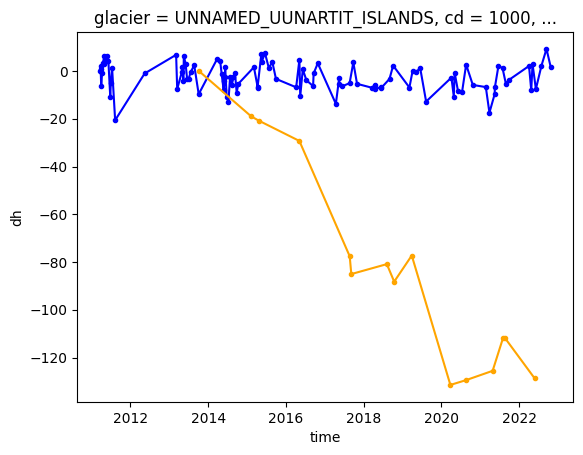

In [7]:
arctic_ds.isel(glacier=0).sel(cd=1000).dh.dropna("time").plot(marker="o", markersize=3, c="blue")
arctic_ds.isel(glacier=1).sel(cd=1000).dh.dropna("time").plot(marker="o", markersize=3, c="orange")

# AST14DEM

Earthdata Search URLs: [Daugaard-Jensen](https://search.earthdata.nasa.gov/search/granules?p=C1299783579-LPDAAC_ECS&pg[0][v]=f&pg[0][gsk]=-start_date&q=ast14dem&sb[0]=-29.49139%2C71.71297%2C-28.44456%2C71.92634&tl=1718099494.537!3!!&lat=71.4770848389968&long=-30.629882812500004&zoom=7), [Uunartit Islands](https://search.earthdata.nasa.gov/search/granules?p=C1299783579-LPDAAC_ECS&pg[0][v]=f&pg[0][gsk]=-start_date&q=ast14dem&sb[0]=-34.42646%2C67.32710%2C-33.27379%2C67.44001&tl=1718099494.537!3!!&lat=67.17482564611342&long=-35.3408203125&zoom=7)

In [5]:
import glob
import re

import geopandas as gpd
import numpy as np
import pdemtools as pdt
import xarray as xr
from rasterio.enums import Resampling

# Metadata for final Dataset
GLOBAL_ATTRS = {
    "author": "U.S./Japan ASTER Science Team",
    "title": "ASTER Digital Elevation Model",
    "shortname": "AST14DEM",
    "version": "v003",
    "doi": "10.5067/ASTER/AST14DEM.003",
    "projection": "3413",
}
VAR_ATTRS = {
    "x": {
        "description": "x coordinate of projection",
        "units": "metres",
    },
    "y": {
        "description": "y coordinate of projection",
        "units": "metres",
    },
    "glacier": {
        "description": "Glacier name, as taken from the Mouginot and others (2019) Greenland basins dataset",
    },
    "h": {
        "description": "Elevation relative to the WGS84 ellipsoid",
        "units": "metres",
    },
    "mosaic": {
        "description": "Elevation relative to the WGS84 ellipsoid from ArcticDEM mosaic",
        "units": "metres",
    },
    "coreg_rmse": {
        "description": "Final RMSE of the coregistration transformation in the vertical (z) dimension from the residuals",
        "units": "metres",
    },
    "coreg_trans_z": {
        "description": "z transformation paramater",
        "units": "metres",
    },
    "coreg_trans_x": {
        "description": "x transformation paramater",
        "units": "metres",
    },
    "coreg_trans_y": {
        "description": "y transformation paramater",
        "units": "metres",
    },
    "coreg_trans_z_err": {
        "description": "1-sigma error of the z transformation paramater",
        "units": "metres",
    },
    "coreg_trans_x_err": {
        "description": "1-sigma error of the x transformation paramater",
        "units": "metres",
    },
    "coreg_trans_y_err": {
        "description": "1-sigma error of the y transformation paramater",
        "units": "metres",
    },
    "creationdate": {
        "description": "Date of scenes2strips processing for the strip DEM",
    },
    "dem_id": {
        "description": "Identifier for the produced DEM strip segment",
        "format": "ALGORTHM_VERSION_SENSOR_DATE_IMAGE1_IMAGE2_SEGMENT_RESOLUTION_FILETYPE",
    },
}

# Path for BedMachine-v5
bedmachine_fpath = "../data/misc/bedmachine/BedMachineGreenland-v5.nc"

# Read and filter centreline points to use for ArcticDEM mosaic download
points = gpd.read_file("../data/misc/centreline_points.geojson")
points = points.sort_values(by=["glacier_code", "cd"])
points = points.loc[points.cd.between(-15000, 40000)].reset_index()

# Process ASTERDEMs for each glacier in turn
for glacier, points_glacier in points.groupby(by="glacier"):
    # Extract bounding coords of centreline points
    bounds = tuple(points_glacier.total_bounds)

    # Download ArcticDEM mosaic to use as reference DEM for coregistration
    reference_dem = pdt.load.mosaic(
        dataset="arcticdem",
        resolution=32,
        bounds=bounds,
        version="v4.1",
    ).squeeze()

    # Load BedMachine-v5 bedrock mask to use as stable terrain for coregistration
    bedrock_mask = pdt.data.bedrock_mask_from_bedmachine(bedmachine_fpath, reference_dem)

    # Load BedMachine-v5 geoid to use in removing ASTERDEM geoid correction
    geoid = pdt.data.geoid_from_bedmachine(bedmachine_fpath, reference_dem)

    # Get ASTERDEMs for current glacier
    files = [f for f in glob.glob(f"../data/elevation/asterdem/{glacier.lower()}/*.tif")]

    # Container to store stack of ASTERDEMs of current glacier
    aster_ds = []

    # Iterate over all identified strip DEMs
    for f in files:
        # Extract granule ID, granule datetime, and creation date from metadata file
        pattern = re.compile(
            r'^\s*OBJECT\s*=\s*(LOCALGRANULEID|PRODUCTIONDATETIME|CALENDARDATE|TIMEOFDAY)\s+.*?^\s*VALUE\s*=\s*("[^"]*"|\S+)',
            re.MULTILINE | re.DOTALL,
        )
        metadata = open(f"{f}.met", "r").read()
        metadata = pattern.finditer(metadata)
        metadata = {obj: val.strip('"') for obj, val in (match.groups() for match in metadata)}

        # Read DEM, reproject to match ArcticDEM mosaic, remove geoid correction, and coregister
        dem = pdt.load.from_fpath(f, bounds=bounds, reproject=3413)
        dem = dem.rio.reproject_match(reference_dem, resampling=Resampling.bilinear, nodata=np.nan)
        dem = dem.pdt.geoid_correct(geoid, reverse=True)
        dem, coreg_trans, coreg_trans_err, coreg_rmse = dem.pdt.coregister(
            reference_dem, bedrock_mask, max_horiz_offset=50, return_stats=True
        )

        # Construct datetime from metadata elements
        dem_datetime = np.datetime64("T".join([metadata["CALENDARDATE"], metadata["TIMEOFDAY"]]))

        # Convert DEM from xarray.DataArray to xarray.Dataset and add time dimension
        dem = dem.to_dataset(name="h").transpose("x", "y")
        dem = dem.expand_dims(dim=["time"])
        dem = dem.assign_coords(time=("time", [dem_datetime]))

        # Add granule ID and creation date metadata
        dem["dem_id"] = ("time", [metadata["LOCALGRANULEID"].strip(".tif")])
        dem["creationdate"] = ("time", [np.datetime64(metadata["PRODUCTIONDATETIME"])])

        # Store coregistration results as data variables
        dem["coreg_rmse"] = ("time", [coreg_rmse])
        dem["coreg_trans_z"] = ("time", [coreg_trans[0]])
        dem["coreg_trans_x"] = ("time", [coreg_trans[1]])
        dem["coreg_trans_y"] = ("time", [coreg_trans[2]])
        dem["coreg_trans_z_err"] = ("time", [coreg_trans_err[0]])
        dem["coreg_trans_x_err"] = ("time", [coreg_trans_err[1]])
        dem["coreg_trans_y_err"] = ("time", [coreg_trans_err[2]])

        aster_ds.append(dem)

    # Construct stack of DEMs for current glacier and add ArcticDEM mosaic subset as data variable
    aster_ds = xr.concat(aster_ds, dim="time")
    aster_ds["mosaic"] = (("x", "y"), reference_dem.transpose("x", "y").data)

    # Expand dimensions with label for current glacier
    aster_ds = aster_ds.expand_dims(glacier=[glacier])

    # Where DEMs have the same date keep only the first (not a perfect solution, but hey ho)
    aster_ds = aster_ds.drop_duplicates("time", keep="first")

    # Assign metadata
    for key, val in VAR_ATTRS.items():
        aster_ds[key].attrs = val
    aster_ds = aster_ds.assign_attrs(GLOBAL_ATTRS)

    # Write current stack of strip DEMs to disk
    aster_ds.to_netcdf(f"../data/elevation/asterdem/elevation_asterdem_granules_{glacier.lower()}.nc")

aster_ds

<xarray.Dataset> Size: 432MB
Dimensions:            (glacier: 1, time: 107, x: 1455, y: 687)
Coordinates:
  * glacier            (glacier) <U24 96B 'UNNAMED_UUNARTIT_ISLANDS'
    spatial_ref        int32 4B ...
  * x                  (x) float64 12kB 4.564e+05 4.565e+05 ... 5.03e+05
  * y                  (y) float64 5kB -2.423e+06 -2.423e+06 ... -2.445e+06
    mapping            int32 4B ...
    band               int32 4B ...
  * time               (time) datetime64[ns] 856B 2001-04-07T14:08:32.657000 ...
Data variables:
    h                  (glacier, time, x, y) float32 428MB ...
    dem_id             (glacier, time) <U48 21kB ...
    creationdate       (glacier, time) datetime64[ns] 856B ...
    coreg_rmse         (glacier, time) float64 856B ...
    coreg_trans_z      (glacier, time) float64 856B ...
    coreg_trans_x      (glacier, time) float64 856B ...
    coreg_trans_y      (glacier, time) float64 856B ...
    coreg_trans_z_err  (glacier, time) float64 856B ...
    coreg_trans_x_err  (glacier, time) float64 856B ...
    coreg_trans_y_err  (glacier, time) float64 856B ...
    mosaic             (glacier, x, y) float32 4MB ...
Attributes:
    author:      U.S./Japan ASTER Science Team
    title:       ASTER Digital Elevation Model
    shortname:   AST14DEM
    version:     v003
    doi:         10.5067/ASTER/AST14DEM.003
    projection:  3413

In [3]:
import dask
import geopandas as gpd
import xarray as xr

# To silence chunk size warning
dask.config.set({"array.slicing.split_large_chunks": True})

# Read, filter, and sort centreline points to use for sampling
points = gpd.read_file("../data/misc/centreline_points.geojson")
points = points.loc[points.cd.between(-15000, 40000)]
points = points.sort_values(by=["glacier", "cd"]).set_index(["glacier", "cd"])

# Extract point coords to use for DEM sampling
points_x = points.geometry.x.to_xarray()
points_y = points.geometry.y.to_xarray()

# Open and merge DEM stack for each glacier
aster_ds = xr.open_mfdataset(
    "../data/elevation/asterdem/elevation_asterdem_granules_*.nc",
    concat_dim="glacier",
    combine="nested",
    chunks="auto",
)

# Sample ASTERDEM granules at each centreline point
aster_ds = aster_ds.sel(x=points_x, y=points_y, method="nearest").transpose("glacier", "cd", "time")

# Calculate change in elevation relative to the first observation at each centreline point
aster_ds_stack = aster_ds.stack(glacier_cd=["glacier", "cd"]).compute()
aster_ds_stack = aster_ds_stack.where(aster_ds_stack.h.notnull(), drop=True)
h = aster_ds_stack.h.groupby("glacier_cd")
h_baseline = aster_ds_stack.h.groupby("glacier_cd").map(lambda x: x.where(x.notnull(), drop=True).isel(time=0))
dh = h - h_baseline
aster_ds["dh"] = dh.unstack("glacier_cd").transpose("glacier", "cd", "time")

# Write to disk
aster_ds["glacier"].encoding = dict(dtype=aster_ds.glacier.dtype.str)
aster_ds.to_netcdf("../data/elevation/asterdem/elevation_asterdem.nc")

aster_ds

C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\xarray\core\indexing.py:1622: PerformanceWarning: Slicing with an out-of-order index is generating 18 times more chunks
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\olive\AppData\Roaming\Python\Python311\site-packages\xarray\core\indexing.py:1622: PerformanceWarning: Slicing with an out-of-order index is generating 13 times more chunks
  value = value[(slice(None),) * axis + (subkey,)]
C:\Users\olive\AppData\Local\Temp\ipykernel_29116\3062609438.py:32: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  h_baseline = aster_ds_stack.h.groupby("glacier_cd").map(lambda x: x.where(x.notnull(), drop=True).isel(time=0))


<xarray.Dataset> Size: 1MB
Dimensions:            (time: 285, glacier: 2, cd: 217)
Coordinates:
  * time               (time) datetime64[ns] 2kB 2000-06-30T14:19:49.593000 ....
  * glacier            (glacier) <U24 192B 'DAUGAARD-JENSEN' 'UNNAMED_UUNARTI...
  * cd                 (cd) int64 2kB -14000 -13750 -13500 ... 39500 39750 40000
    x                  (glacier, cd) float64 3kB 5.624e+05 ... 4.564e+05
    y                  (glacier, cd) float64 3kB -1.892e+06 ... -2.445e+06
    spatial_ref        int32 4B 0
    mapping            int32 4B 0
    band               int32 4B 1
Data variables:
    h                  (glacier, cd, time) float32 495kB dask.array<chunksize=(2, 217, 4), meta=np.ndarray>
    dem_id             (glacier, time) object 5kB dask.array<chunksize=(1, 285), meta=np.ndarray>
    creationdate       (glacier, time) datetime64[ns] 5kB dask.array<chunksize=(1, 285), meta=np.ndarray>
    coreg_rmse         (glacier, time) float64 5kB dask.array<chunksize=(1, 285), meta=np.ndarray>
    coreg_trans_z      (glacier, time) float64 5kB dask.array<chunksize=(1, 285), meta=np.ndarray>
    coreg_trans_x      (glacier, time) float64 5kB dask.array<chunksize=(1, 285), meta=np.ndarray>
    coreg_trans_y      (glacier, time) float64 5kB dask.array<chunksize=(1, 285), meta=np.ndarray>
    coreg_trans_z_err  (glacier, time) float64 5kB dask.array<chunksize=(1, 285), meta=np.ndarray>
    coreg_trans_x_err  (glacier, time) float64 5kB dask.array<chunksize=(1, 285), meta=np.ndarray>
    coreg_trans_y_err  (glacier, time) float64 5kB dask.array<chunksize=(1, 285), meta=np.ndarray>
    mosaic             (glacier, cd) float32 2kB dask.array<chunksize=(2, 217), meta=np.ndarray>
    dh                 (glacier, cd, time) float32 495kB nan nan ... -1.311e+03
Attributes:
    author:      U.S./Japan ASTER Science Team
    title:       ASTER Digital Elevation Model
    shortname:   AST14DEM
    version:     v003
    doi:         10.5067/ASTER/AST14DEM.003
    projection:  3413

# ArcticDEM & AST14DEM

In [11]:
import xarray as xr

# Open and merge ArcticDEM and ASTERDEM elevation samples into one Dataset
arctic_ds = xr.open_dataset("../data/elevation/arcticdem/elevation_arcticdem.nc")
aster_ds = xr.open_dataset("../data/elevation/asterdem/elevation_asterdem.nc")
elevation_ds = xr.combine_by_coords([arctic_ds, aster_ds], combine_attrs="drop_conflicts")

# Populate DEM source variable
elevation_ds["dem_id"] = elevation_ds.dem_id.astype(str)
elevation_ds["source"] = elevation_ds.dem_id.str.extract(pat=r"^(SETSM|AST14DEM)", dim=None)

# Rough filtering of bad data
elevation_ds = elevation_ds.where(elevation_ds.h < 1500, drop=True)
elevation_ds = elevation_ds.where(elevation_ds.coreg_rmse < 100, drop=True)

# Calculate change in elevation relative to the first observation at each centreline point
elevation_ds_stack = elevation_ds.stack(glacier_cd=["glacier", "cd"]).compute()
elevation_ds_stack = elevation_ds_stack.where(elevation_ds_stack.h.notnull(), drop=True)
h = elevation_ds_stack.h.groupby("glacier_cd")
h_baseline = elevation_ds_stack.h.groupby("glacier_cd").map(lambda x: x.where(x.notnull(), drop=True).isel(time=0))
dh = h - h_baseline
elevation_ds["dh_merged"] = dh.unstack("glacier_cd").transpose("glacier", "cd", "time")

elevation_ds.to_netcdf("../data/elevation/elevation.nc")
elevation_ds

C:\Users\olive\AppData\Local\Temp\ipykernel_37420\515198979.py:20: UserWarning: The `squeeze` kwarg to GroupBy is being removed.Pass .groupby(..., squeeze=False) to disable squeezing, which is the new default, and to silence this warning.
  h_baseline = elevation_ds_stack.h.groupby("glacier_cd").map(lambda x: x.where(x.notnull(), drop=True).isel(time=0))
C:\Users\olive\AppData\Local\Temp\ipykernel_37420\515198979.py:24: UserWarning: Times can't be serialized faithfully to int64 with requested units 'seconds since 2010-08-11T08:01:56'. Serializing with units 'milliseconds since 2010-08-11T08:01:56' instead. Set encoding['dtype'] to floating point dtype to serialize with units 'seconds since 2010-08-11T08:01:56'. Set encoding['units'] to 'milliseconds since 2010-08-11T08:01:56' to silence this warning .
  elevation_ds.to_netcdf("../data/elevation/elevation.nc")


<xarray.Dataset> Size: 33MB
Dimensions:                      (glacier: 2, cd: 217, time: 352)
Coordinates:
  * time                         (time) datetime64[ns] 3kB 2000-06-30T14:19:4...
  * glacier                      (glacier) <U24 192B 'DAUGAARD-JENSEN' 'UNNAM...
  * cd                           (cd) int64 2kB -14000 -13750 ... 39750 40000
    x                            (glacier, cd) float64 3kB 5.624e+05 ... 4.56...
    y                            (glacier, cd) float64 3kB -1.892e+06 ... -2....
    spatial_ref                  int32 4B 0
    mapping                      int32 4B 0
    band                         int32 4B 1
Data variables: (12/29)
    h                            (glacier, cd, time) float32 611kB nan ... nan
    dem_id                       (glacier, time, cd) object 1MB nan nan ... nan
    pairname                     (glacier, time, cd) object 1MB nan nan ... nan
    stripdemid                   (glacier, time, cd) object 1MB nan nan ... nan
    acqdate1                     (glacier, time, cd) datetime64[ns] 1MB NaT ....
    acqdate2                     (glacier, time, cd) datetime64[ns] 1MB NaT ....
    ...                           ...
    coreg_trans_x_err            (glacier, time, cd) float64 1MB nan nan ... nan
    coreg_trans_y_err            (glacier, time, cd) float64 1MB nan nan ... nan
    mosaic                       (glacier, cd, time) float32 611kB nan ... nan
    dh                           (glacier, cd, time) float32 611kB nan ... nan
    source                       (glacier, time, cd) object 1MB nan nan ... nan
    dh_merged                    (glacier, cd, time) float32 611kB nan ... nan
Attributes:
    institution:  Polar Geospatial Center (PGC), College of Science and Engin...
    region:       RGI05A
    projection:   3413
    shortname:    AST14DEM
    doi:          10.5067/ASTER/AST14DEM.003

Quick view of combined AST14DEM & ArcticDEM time series for Uunartit Islands

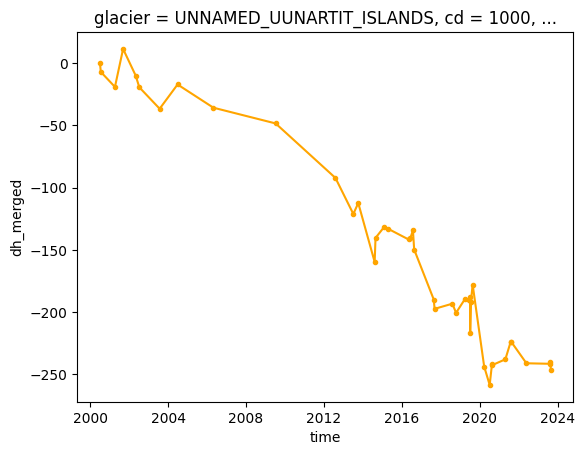

In [12]:
elevation_ds.isel(glacier=1).sel(cd=1_000).dh_merged.dropna("time").plot(marker="o", markersize=3, c="orange")

Linear trend

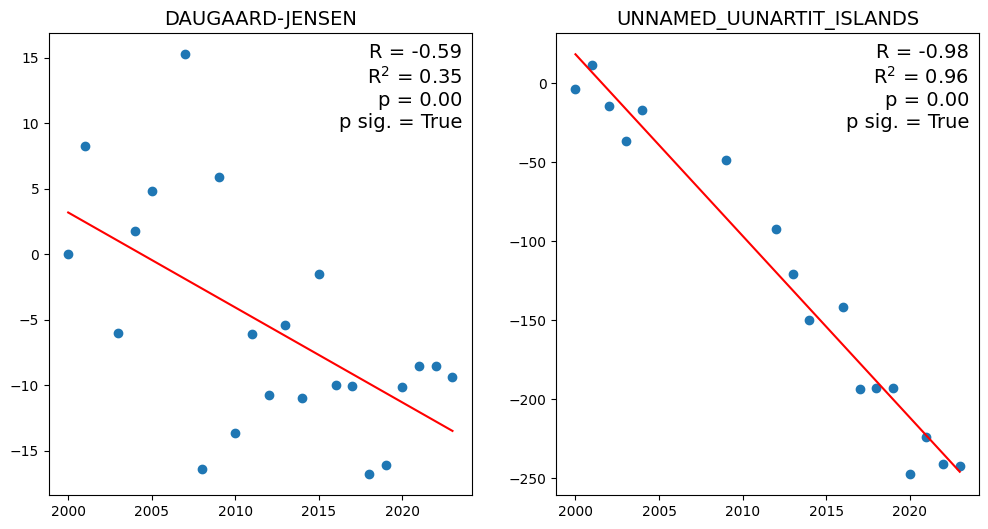

In [14]:
import matplotlib.pyplot as plt
import scipy
import xarray as xr
from matplotlib.gridspec import GridSpec
from matplotlib.offsetbox import AnchoredText

# Set up axes
fig = plt.figure(figsize=(12, 6))
gs = GridSpec(nrows=1, ncols=2, width_ratios=(1, 1))
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
axs = [ax0, ax1]

elevation_ds = xr.open_dataset("../data/elevation/elevation.nc")

for i, (glacier, ds) in enumerate(elevation_ds.groupby("glacier", squeeze=False)):
    ds = ds.where(ds.coreg_rmse < 100).sel(cd=1_000)
    dh = ds.dh_merged.squeeze().sel(time=ds.dh_merged.time.dt.month.isin([5, 6, 7, 8, 9]))
    dh = dh.resample(time="1YS").mean()
    years = dh.time.dt.year

    # Mask null values
    mask = dh.notnull() & years.notnull()
    dh = dh.where(mask, drop=True)
    years = years.where(mask, drop=True)

    # Regress relative elevation changes against year
    res = scipy.stats.linregress(years, dh)

    # Plot data and trendline
    axs[i].plot(years, dh, "o")
    axs[i].plot(years, res.intercept + res.slope * years, "r", label="fitted line")

    # Add R2 and p values to plot
    axs[i].add_artist(
        AnchoredText(
            f"R = {res.rvalue:.2f}\nR$^{{2}}$ = {res.rvalue**2:.2f}\np = {res.pvalue:.2f}\np sig. = {res.pvalue < 0.05}",
            loc="upper right",
            borderpad=0.1,
            prop=dict(fontsize=14, horizontalalignment="right"),
            frameon=False,
        )
    )

    # Label plots
    axs[i].set_title(glacier, fontsize=14)

plt.show()

# ICESat-2 ATL15

Run batch file to download ICESat-2 [ATL15](https://doi.org/10.5067/ATLAS/ATL15.003) Gridded Arctic Land Ice Height Change dataset

In [ ]:
!cd ../data/elevation/icesat2 & elevation_icesat2_download.bat

Sample ATL15 grid at centreline points

In [21]:
import geopandas as gpd
import xarray as xr

# Open ATL15 grid
atl_ds = xr.open_dataset(
    "../data/elevation/icesat2/ATL15_GL_0318_01km_003_01.nc",
    group="delta_h",
    chunks={"x": "auto", "y": "auto"},
)

# Read, filter, and sort centreline points
points = gpd.read_file("../data/misc/centreline_points.geojson")
points = points.loc[points.cd.between(-15000, 40000)]
points = points.sort_values(by=["glacier", "cd"]).set_index(["glacier", "cd"])

# Extract point coords to use for sampling
points_x = points.geometry.x.to_xarray()
points_y = points.geometry.y.to_xarray()

# Sample ATL15 data at each centreline point
atl_ds_sampled = atl_ds.sel(x=points_x, y=points_y, method="nearest").transpose("glacier", "cd", "time")
atl_ds_sampled = atl_ds_sampled.compute()
atl_ds_sampled

<xarray.Dataset> Size: 207kB
Dimensions:              (glacier: 2, cd: 217, time: 19)
Coordinates:
    x                    (glacier, cd) float64 3kB 8.7e+05 8.7e+05 ... 4.56e+05
    y                    (glacier, cd) float64 3kB -6.1e+05 ... -2.445e+06
  * time                 (time) datetime64[ns] 152B 2018-10-01T22:30:00 ... 2...
  * glacier              (glacier) object 16B 'DAUGAARD-JENSEN' 'UNNAMED_UUNA...
  * cd                   (cd) int64 2kB -14000 -13750 -13500 ... 39750 40000
Data variables:
    Polar_Stereographic  int8 1B -127
    ice_area             (glacier, cd, time) float32 33kB nan nan ... 9.826e+05
    delta_h              (glacier, cd, time) float32 33kB nan nan ... -6.737
    delta_h_sigma        (glacier, cd, time) float32 33kB nan nan ... 0.05951
    data_count           (glacier, cd, time) float32 33kB nan nan ... 5.059
    misfit_rms           (glacier, cd, time) float32 33kB nan nan ... 0.2797
    misfit_scaled_rms    (glacier, cd, time) float32 33kB nan nan ... 5.659
Attributes:
    description:  delta_h group includes variables describing height differen...

Quick view of ATL15 time series

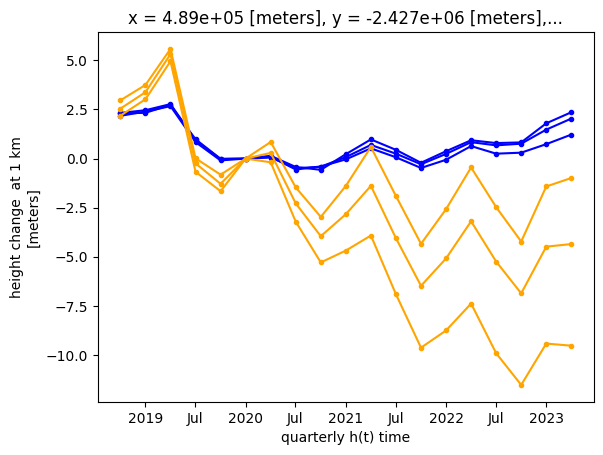

In [22]:
atl_ds_sampled.sel(glacier="DAUGAARD-JENSEN", cd=10_000).delta_h.plot(marker="o", markersize=3, c="blue")
atl_ds_sampled.sel(glacier="DAUGAARD-JENSEN", cd=5_000).delta_h.plot(marker="o", markersize=3, c="blue")
atl_ds_sampled.sel(glacier="DAUGAARD-JENSEN", cd=1_000).delta_h.plot(marker="o", markersize=3, c="blue")
atl_ds_sampled.sel(glacier="UNNAMED_UUNARTIT_ISLANDS", cd=10_000).delta_h.plot(marker="o", markersize=3, c="orange")
atl_ds_sampled.sel(glacier="UNNAMED_UUNARTIT_ISLANDS", cd=5_000).delta_h.plot(marker="o", markersize=3, c="orange")
atl_ds_sampled.sel(glacier="UNNAMED_UUNARTIT_ISLANDS", cd=1_000).delta_h.plot(marker="o", markersize=3, c="orange")

Amimation of ATL15 grid over time

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.animation import FuncAnimation

# Increase byte limit for animation
plt.rcParams["animation.embed_limit"] = 1e8

# Read centreline points
points = gpd.read_file("../data/misc/centreline_points.geojson")
points = points.sort_values(by=["glacier_code", "cd"])
points = points.loc[points.cd.between(-15000, 40000)]

# Open ATL15 grid
atl_ds = xr.open_dataset(
    "../data/elevation/icesat2/ATL15_GL_0318_01km_003_01.nc",
    group="delta_h",
    chunks={"x": "auto", "y": "auto"},
)

# Set up axes
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Get centreline point coords and bounds of centreline for each glacier
points_ax0 = points.loc[points.glacier == "DAUGAARD-JENSEN"].reset_index()
points_ax1 = points.loc[points.glacier == "UNNAMED_UUNARTIT_ISLANDS"].reset_index()
bounds_ax0 = tuple(points_ax0.total_bounds)
bounds_ax1 = tuple(points_ax1.total_bounds)

# Expand centreline bounds for wider plot area
x_slice_ax0 = slice(bounds_ax0[0] - 10_000, bounds_ax0[2] + 10_000)
y_slice_ax0 = slice(bounds_ax0[1] - 10_000, bounds_ax0[3] + 10_000)
x_slice_ax1 = slice(bounds_ax1[0] - 10_000, bounds_ax1[2] + 10_000)
y_slice_ax1 = slice(bounds_ax1[1] - 10_000, bounds_ax1[3] + 10_000)

# Subset ATL15 data by plot areas
atl_ds_ax0 = atl_ds.sel(x=x_slice_ax0, y=y_slice_ax0)
atl_ds_ax1 = atl_ds.sel(x=x_slice_ax1, y=y_slice_ax1)

# Plot initial frame of ATL15 data
map_ax0 = atl_ds_ax0.isel(time=0).delta_h.plot(
    ax=axs[0], add_colorbar=True, cmap="viridis", vmin=-2, vmax=2, cbar_kwargs={"extend": "neither"}
)
map_ax1 = atl_ds_ax1.isel(time=0).delta_h.plot(
    ax=axs[1], add_colorbar=True, cmap="viridis", vmin=-2, vmax=2, cbar_kwargs={"extend": "neither"}
)

# Plot centreline points
axs[0].plot(points_ax0.geometry.x.values, points_ax0.geometry.y.values, marker="o", markersize=2, c="red", alpha=0.5)
axs[1].plot(points_ax1.geometry.x.values, points_ax1.geometry.y.values, marker="o", markersize=2, c="red", alpha=0.5)


# Animation function
def animate(frame):
    map_ax0.set_array(atl_ds_ax0.delta_h[frame, :, :].values.flatten())
    map_ax1.set_array(atl_ds_ax1.delta_h[frame, :, :].values.flatten())
    axs[0].set_title(f"time={str(atl_ds_ax0.delta_h.time.isel(time=frame).values)[:7]}")
    axs[1].set_title("")


anim = FuncAnimation(fig, animate, frames=atl_ds.time.size, interval=200)
anim.save("../img/elevation_icesat2_anim.mp4")

# CryoTEMPO-EOLIS

Run batch file to download all Cryo-TEMPO EOLIS gridded granules for Greenland from the [ESA CryoSat-2 Science Server](https://science-pds.cryosat.esa.int/#Cry0Sat2_data/TEMPO_SWATH_GRID)

In [ ]:
!cd ../data/elevation/eolis & elevation_eolis_download.bat

Stack and sample EOLIS granules

In [24]:
import glob

import geopandas as gpd
import pandas as pd
import xarray as xr

# Read, filter, and sort centreline points
points = gpd.read_file("../data/misc/centreline_points.geojson")
points = points.loc[points.cd.between(-15000, 40000)]
points = points.sort_values(by=["glacier", "cd"]).set_index(["glacier", "cd"])

# Extract point coords to use for sampling EOLIS data
points_x = points.geometry.x.to_xarray()
points_y = points.geometry.y.to_xarray()

# Collect and open all EOLIS granules
files = glob.glob(f"../data/elevation/eolis/CS_OFFL_THEM_GRID__GREENLAND_*.nc")
eolis_ds = xr.open_mfdataset(files)

# Convert epoch to datetime and subset data to only keep full years (2011-2023)
eolis_ds["time"] = pd.to_datetime(eolis_ds.time, unit="s")
eolis_ds = eolis_ds.sel(time=slice("2011-01-01", "2024-01-01"))

# Drop unecessary vars
eolis_ds = eolis_ds.drop_dims("nv")
eolis_ds = eolis_ds.transpose("time", "y", "x")
eolis_ds.to_netcdf("../data/elevation/eolis/elevation_eolis_granules.nc")

# Sample EOLIS granules at each centreline point
eolis_ds = eolis_ds.sel(x=points_x, y=points_y, method="nearest").transpose("glacier", "cd", "time")

# Calculate change in elevation relative to first observation (2011-01)
eolis_ds_stack = eolis_ds.stack(glacier_cd=["glacier", "cd"]).compute()
h = eolis_ds_stack.elevation.groupby("glacier_cd")
h_baseline = eolis_ds_stack.elevation.groupby("glacier_cd").first().isel(time=0)
dh = h - h_baseline
eolis_ds["dh"] = dh.unstack("glacier_cd").transpose("glacier", "cd", "time")

eolis_ds.to_netcdf("../data/elevation/eolis/elevation_eolis.nc")
eolis_ds

<xarray.Dataset> Size: 819kB
Dimensions:      (glacier: 2, cd: 217, time: 156)
Coordinates:
    x            (glacier, cd) float32 2kB 8.99e+05 8.99e+05 ... 4.57e+05
    y            (glacier, cd) float32 2kB -6.01e+05 -6.01e+05 ... -2.445e+06
  * time         (time) datetime64[ns] 1kB 2011-01-15 2011-02-15 ... 2023-12-15
  * glacier      (glacier) object 16B 'DAUGAARD-JENSEN' 'UNNAMED_UUNARTIT_ISL...
  * cd           (cd) int64 2kB -14000 -13750 -13500 ... 39500 39750 40000
Data variables:
    elevation    (glacier, cd, time) float32 271kB dask.array<chunksize=(2, 217, 1), meta=np.ndarray>
    uncertainty  (glacier, cd, time) float32 271kB dask.array<chunksize=(2, 217, 1), meta=np.ndarray>
    dh           (glacier, cd, time) float32 271kB nan nan nan ... -22.47 -22.19
Attributes: (12/35)
    cdm_data_type:                Gridded
    Conventions:                  CF-1.7
    Metadata_Conventions:         Unidata Dataset Discovery v1.0
    contact:                      support@cryotempo-eolis.org
    creator_email:                support@cryotempo-eolis.org
    creator_url:                  http://cryotempo-eolis.org/
    ...                           ...
    project:                      CryoTEMPO-EOLIS, which is an evolution of C...
    references:                   CryoSat-2 swath interferometric altimetry f...
    source:                       Gridded Swath data generated from CryoSat-2...
    time_coverage_duration:       P3M
    time_coverage_start:          2010-07-01T00:00:00+00:00
    time_coverage_end:            2010-09-30T23:59:59+00:00

Coverage of EOLIS data along glacier flowlines

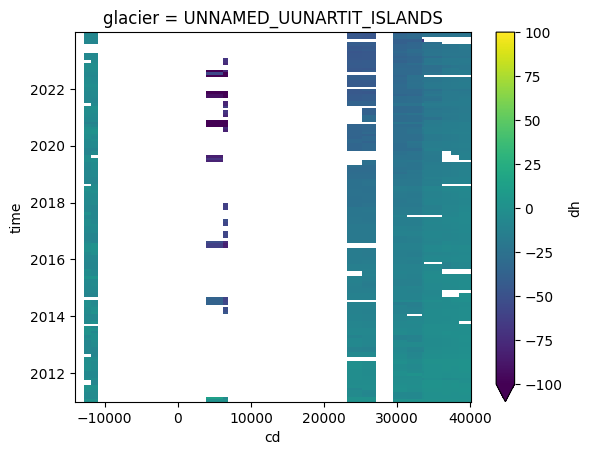

In [25]:
eolis_ds.sel(glacier="UNNAMED_UUNARTIT_ISLANDS").dh.plot(x="cd", vmin=-100, vmax=100)

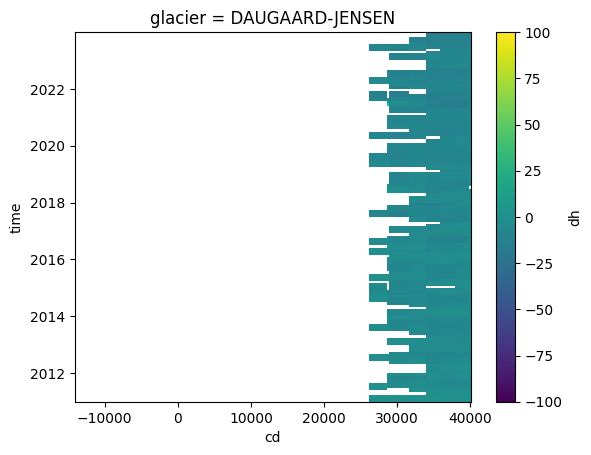

In [26]:
eolis_ds.sel(glacier="DAUGAARD-JENSEN").dh.plot(x="cd", vmin=-100, vmax=100)

Time series of elevation changes from relatively far up-glacier

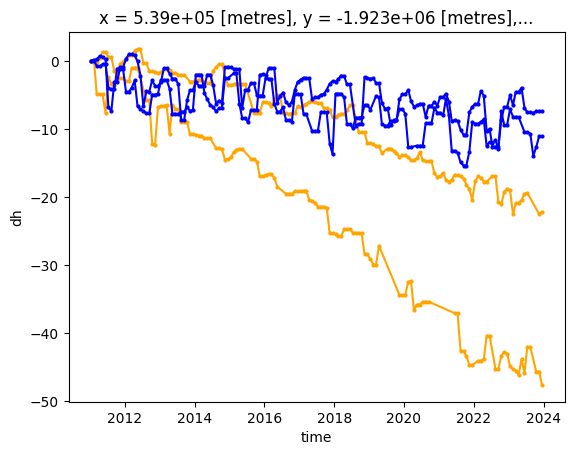

In [27]:
eolis_ds.sel(glacier="UNNAMED_UUNARTIT_ISLANDS", cd=40_000).dh.dropna("time").plot(marker="o", markersize=2, c="orange")
eolis_ds.sel(glacier="UNNAMED_UUNARTIT_ISLANDS", cd=25_000).dh.dropna("time").plot(marker="o", markersize=2, c="orange")
eolis_ds.sel(glacier="DAUGAARD-JENSEN", cd=40_000).dh.dropna("time").plot(marker="o", markersize=2, c="blue")
eolis_ds.sel(glacier="DAUGAARD-JENSEN", cd=35_000).dh.dropna("time").plot(marker="o", markersize=2, c="blue")

Animation that plots each time slice of EOLIS data

In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import xarray as xr
from matplotlib.animation import FuncAnimation

# Increase byte limit for animation
plt.rcParams["animation.embed_limit"] = 1e8

# Read centreline points
points = gpd.read_file("../data/misc/centreline_points.geojson")
points = points.sort_values(by=["glacier_code", "cd"])
points = points.loc[points.cd.between(-15000, 40000)]

# Read EOLIS data
eolis_ds = xr.open_dataset("../data/elevation/eolis/elevation_eolis_granules.nc")

# Set up axes
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(12, 12))

# Get centreline point coords and bounds of centreline for each glacier
points_ax0 = points.loc[points.glacier == "DAUGAARD-JENSEN"].reset_index()
points_ax1 = points.loc[points.glacier == "UNNAMED_UUNARTIT_ISLANDS"].reset_index()
bounds_ax0 = tuple(points_ax0.total_bounds)
bounds_ax1 = tuple(points_ax1.total_bounds)

# Expand centreline bounds for wider plot area
x_slice_ax0 = slice(bounds_ax0[0] - 100_000, bounds_ax0[2] + 100_000)
y_slice_ax0 = slice(bounds_ax0[1] - 100_000, bounds_ax0[3] + 100_000)
x_slice_ax1 = slice(bounds_ax1[0] - 100_000, bounds_ax1[2] + 100_000)
y_slice_ax1 = slice(bounds_ax1[1] - 100_000, bounds_ax1[3] + 100_000)

# Subset EOLIS data by plot areas
eolis_ds_ax0 = eolis_ds.sel(x=x_slice_ax0, y=y_slice_ax0)
eolis_ds_ax1 = eolis_ds.sel(x=x_slice_ax1, y=y_slice_ax1)

# Plot initial frame of EOLIS data
map_ax0 = eolis_ds_ax0.isel(time=0).elevation.plot(
    ax=axs[0], add_colorbar=True, cmap="cividis_r", vmin=0, vmax=3000, cbar_kwargs={"extend": "neither"}
)
map_ax1 = eolis_ds_ax1.isel(time=0).elevation.plot(
    ax=axs[1], add_colorbar=True, cmap="cividis_r", vmin=0, vmax=3000, cbar_kwargs={"extend": "neither"}
)

# Plot centreline points
axs[0].plot(points_ax0.geometry.x.values, points_ax0.geometry.y.values, marker="o", markersize=2, c="red", alpha=0.5)
axs[1].plot(points_ax1.geometry.x.values, points_ax1.geometry.y.values, marker="o", markersize=2, c="red", alpha=0.5)


# Animation function
def animate(frame):
    map_ax0.set_array(eolis_ds_ax0.elevation[frame, :, :].values.flatten())
    map_ax1.set_array(eolis_ds_ax1.elevation[frame, :, :].values.flatten())
    axs[0].set_title(f"time={str(eolis_ds_ax0.elevation.time.isel(time=frame).values)[:7]}")
    axs[1].set_title("")


anim = FuncAnimation(fig, animate, frames=eolis_ds.time.size, interval=200)
anim.save("../img/elevation_eolis_anim.mp4")